# Card Detection

In [38]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

def display_image(image, title=None, cmap=None, max_size=(800, 800)):
    """
    Display an image using matplotlib after resizing it to a smaller size.

    Parameters:
    - image: The image to display.
    - title: The title of the image (optional).
    - cmap: The colormap to use for displaying the image (optional).
    - max_size: The maximum size (width, height) to resize the image to (default is (400, 400)).
    """
    # Resize the image to fit within the max_size while maintaining the aspect ratio
    h, w = image.shape[:2]
    scaling_factor = min(max_size[0] / w, max_size[1] / h)
    new_size = (int(w * scaling_factor), int(h * scaling_factor))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Convert color from BGR (OpenCV) to RGB (Matplotlib)
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(4, 4))  # Adjust the figsize to make the display smaller
    if title:
        plt.title(title)
    plt.imshow(resized_image, cmap=cmap)
    plt.axis('off')
    plt.show()

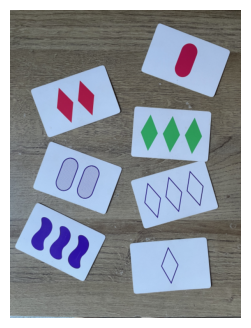

In [39]:
# Load the image using OpenCV
image = cv2.imread('./static/ex-1.png')
image = imutils.resize(image, width=500)

# Display the image
display_image(image=image)


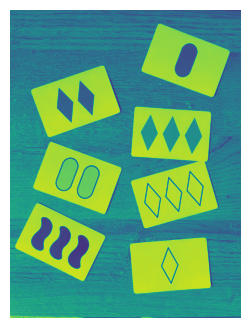

In [40]:
# Apply grey scale filter
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

display_image(gray)


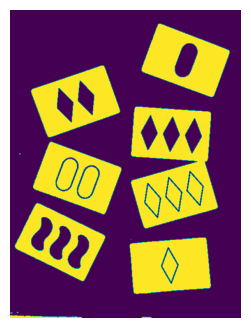

In [41]:
# Gaussian blur the image.
blur = cv2.GaussianBlur(gray, (3, 3), 0)

# Otsu's threshold
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

display_image(thresh)

Contours detected: 7


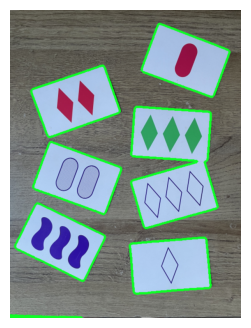

In [42]:
# Find contours and filter for cards using contour area
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the contours list. Depending on OpenCV version, this is a different 
# in the return list.
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# We don't want to capture the smaller shapes, only the cards. So set a 
# threshold here. 
# TODO: make this dynamic (ie, find contours and then choose threshold 
#       to filter out the cards)
threshold_min_area = 400
number_of_contours = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > threshold_min_area:
        cv2.drawContours(image, [c], 0, (36,255,12), 3)
        number_of_contours += 1

print("Contours detected:", number_of_contours)

display_image(image)